# Modelizado Experimental

***Encontrar modelos de sistemas a partir de datos experimentales y probar controladores en dichos sistemas.***

In [1]:
# Importamos librerias que utilizaremos en el notebook

%matplotlib inline

import control
import matplotlib.pyplot as plt
import numpy
import sympy
import ipywidgets as widgets
import serial                      # pip install pyserial
import scipy

<table>
    <tr></tr>
    <tr>
        <td><img src="http://cpm.davinsony.com/clases/svg/python.svg" width="100px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/pyserial.png" width="200px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/scipy.png" width="200px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/sympy.svg" width="130px"></td>
    </tr>
</table>
<table>
    <tr>
    </tr>
    <tr>       
        <td><img src="http://cpm.davinsony.com/clases/svg/matplotlib.svg" width="300px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/numpy.svg" width="200px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/ipywidgets.svg" width="200px"></td>
    </tr>
</table>

## Modelizado experimental de un sistema de iluminación 

Para entender el modelizado experimental usaremos una maqueta (planta) para el control de iluminación. 

La planta es un sistema de iluminación con un LED *Light Emitter Diode* de potencia (actuador) y un LDR *Light Dependent Resistor* (sensor). Este sistema es controlado a través de un **Arduino X**.

<img src="https://cpm.davinsony.com/media/image/iluminacion/planta.png" title="Maqueta de laboratorio para el control de iluminación." width="350px"/>

Encontrar el modelo de forma analitica para este sistema puede ser dificil dado que no todos tenemos conocimientos en óptica. Por lo que para encontrar el modelo matemático de este, usaremos datos experimentales. 


### 1. Subir el Código **Arduino**

Abramos el archivo [`iluminacion.ino)`](http://cpm.davinsony.com/arduino/iluminacion/iluminacion.ino) en el **Arduino IDE** (IDE *Integrated Development Environment*). Este código nos permitira actuar el LED y obtener los datos del sensor. Para interactuar con el arduino usaremos el puerto serial y python.

Para ubicar el puerto de comunicación serial vamos al menú `Herramientas` `>` `Puerto`. Seleccionamos el puerto donde se encuentre el **Arduino X**.

![selección del puerto](https://cpm.davinsony.com/media/image/iluminacion/verificacion_puerto.png "Verificación del puerto utilizando el Arduino IDE")

Verificamos en la maqueta donde se tiene conectada la entrada y la salida. Y corregimos los pines en el código.

``` c
#define OUT 2
#define IN A0
```

Luego, subimos el código al **Arduino X**.

![boton subir en el Arduino IDE](https://cpm.davinsony.com/media/image/iluminacion/arduino_subir.png "Botón subir del Arduino IDE")

Este código básicamente lee la información del sensor y la envía por puerto serial al computador, esta información esta codificada en código `ASCII`. Adicionalmente si uno envía un valor (`0-255`) por el puerto serial al **Arduino**, este cambiará la intensidad del LED proporcionalmente a este valor.  

> Una vez subido el código al **Arduino** se puede verificar vía el Monitor Serie la recepción de caracteres `ASCII`, enviando cualquier carácter, el carácter recibido debería cambiar.

Si se se niega el acceso al puerto serial en linux se pueden cambiar los permisos del puerto, de la siguiente forma: 

``` bash
sudo chmod 777 /dev/ttyACM0
```

In [2]:
serialPort = '/dev/ttyACM0'

##############

ser = serial.Serial(serialPort, 115200, timeout=5)
ser.flushInput()
ser.flushOutput()

T = []
X = []
Y = []

i = 0
while i < 300 :

    # Enviar datos al actuador
    if i < 100 :
        ser.write(bytes.fromhex('00'))
    else :
        ser.write(bytes.fromhex('FF'))

    # Recibir el mensaje del Arduino
    mensaje = ser.readline()
    ser.flushInput()

    # Mostrar señal 
    if len(mensaje) > 0 :
        data = mensaje.decode().strip('\n').strip('\r').split(",")
        if len(data) == 3:
            print(".", end = "")
            T.append(float(data[0])/1000)
            X.append(data[1])
            Y.append(data[2])

    # Incrementar contador
    i += 1

print('\n\n> Completo',end = "")    
ser.write(bytes.fromhex('00'))
ser.close()

..........................................................................................................................................................................................................................................................................................................

> Completo

### 2. Análisis de la toma de datos

Despues de ejecutar el código de python que genera cambios en el actuador, tenemos la siguiente respuesta. 

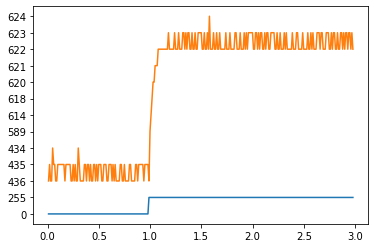

In [3]:
plt.plot(T,X)
plt.plot(T,Y)
plt.show()

Vamos a filtrar la respuesta con un promedio (*average*). 

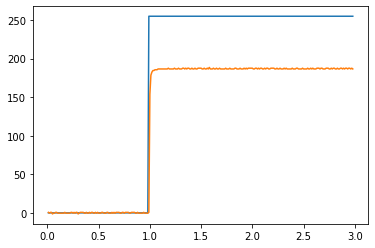

In [4]:
t = numpy.array(T)
x = numpy.array(X)
y = numpy.array(Y)

x = x.astype(float)
y = y.astype(float)

y = y - numpy.average(y[0:50])

plt.plot(t,x)
plt.plot(t,y)
plt.show()

Hagamos zoom en donde se genera el escalón:

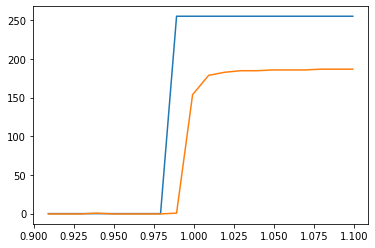

In [5]:
plt.plot(t[90:110],x[90:110])
plt.plot(t[90:110],y[90:110])
plt.show()

Respodamos las siguientes preguntas:
    
- ¿El sistema es de primer o segundo orden?
- ¿Cuál es su ganancia $\gamma$? 
- ¿Cuál es su frecuencia angular natural $\omega_n$?
- ¿Cuál es su coefficiente de amortiguamiento $\xi$?
- ¿Cuál es su constante de tiempo?

### 3. Indentificación paramétrica

Para encontrar los paramétros del sistema.

$$\frac{\gamma}{\tau\, s + 1}\, e^{-\theta\,s}$$

debemos referirnos a la curva experimental. 

- La ganancia puede ser calculada como:
    $$\gamma = \frac{y_\infty - y_0}{u_\infty - u_0}$$
- El retardo $\theta$ es el tiempo que se demora la salida en responder ante un cambio de la entrada en el sistema. 
- El tiempo de establecimieto $\tau$ es el tiempo que se demora la respuesta en alcazar un $63.2\%$ del su valor final. 

In [8]:
## Parametros del modelo

p_gamma = widgets.FloatSlider(value=0.76,min=0,max=2,step=0.01,description='gamma')
p_tau   = widgets.FloatSlider(value=0.005,min=0,max=0.01,step=0.001,description='tau')
p_theta = widgets.FloatSlider(value=0.01,min=0,max=0.1,step=0.01,description='theta')

## Definicion de la simulacion

def identificacion(gamma,tau,theta):
    fo = control.tf([gamma],[tau,1])

    dt_num,dt_den = control.pade(theta,1)
    delay = control.tf(dt_num,dt_den)

    fodt = fo*delay

    tin = numpy.linspace(0.01, 3, len(t))

    tsim, ysim, xsim = control.forced_response(fodt, tin, x, X0= 0.0)

    for i in range(0,len(ysim)):
        ysim[i] = max(ysim[i],0)

    ax = plt.subplot(111)
    ax.plot(t,x, label="actuador")
    ax.plot(t,y, label="respuesta experiemental")
    ax.plot(tsim, ysim, label="respuesta simulada")
    ax.legend()    
    plt.title('Comparación modelo con respuesta experimental')
    plt.xlabel('tiempo (t)')
    plt.ylabel('respuesta')

## Presentación de los resultados    
    
plot_identificacion = widgets.interactive_output(identificacion,{'gamma':p_gamma,'tau':p_tau,'theta':p_theta})      
widgets.HBox([widgets.VBox([p_gamma,p_tau,p_theta]),plot_identificacion])

Con los parámetros obtenidos podemos simular el sistema y verificar que tan cerca esta del comportamiento real. 

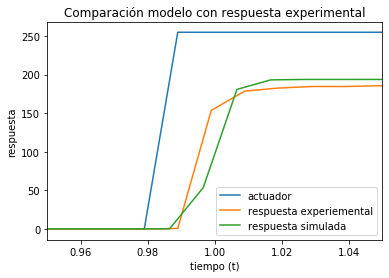

In [9]:
identificacion(0.76,0.003,0.005)
plt.xlim(0.95,1.05);

### 4. Optimización paramétrica

Por otro lado los parametros que encontramos manualmente, se puede buscar utilizando optimizadores que ya estan disponibles en python, en la libreria **Scipy**. 

Optimizando los paramátros del nuestro sistema experimental tenemos: 

In [11]:
def simulador(x,gamma,theta,tau):

    fo = control.tf([gamma],[tau,1])

    dt_num,dt_den = control.pade(theta,1)
    delay = control.tf(dt_num,dt_den)

    fodt = fo*delay

    tin = numpy.linspace(0.01, 3, len(t))

    tsim, ysim, xsim = control.forced_response(fodt, tin, x, X0= 0.0)

    for i in range(0,len(ysim)):
        ysim[i] = max(ysim[i],0)
    
    return ysim

popt, pcov = scipy.optimize.curve_fit(simulador, x, y, bounds=([0.001,0.001,0.001], [3., 1., 0.5]))

gamma = popt[0]
theta = popt[1]
tau   = popt[2]

print(" - gamma = %2.4f\n - tau   = %2.4f\n - theta = %2.4f" %(gamma,tau,theta))

ysim = simulador(x,gamma,theta,tau)

 - gamma = 0.7332
 - tau   = 0.0010
 - theta = 0.0113


In [12]:
## Parametros
p_xmin = widgets.FloatSlider(value=0,min=0,max=3,step=0.1,description='xmin')
p_xmax = widgets.FloatSlider(value=2,min=0,max=3,step=0.1,description='xmax')

## Grafico interactivo
def resultado_optimizacion(xmin,xmax):
    ax = plt.subplot(111)
    ax.plot(t,x, label="actuador")
    ax.plot(t,y, label="respuesta experiemental")
    ax.plot(t, ysim, label="respuesta simulada")
    ax.legend()
    plt.title('Comparación modelo con respuesta experimental')
    plt.xlabel('tiempo (t)')
    plt.ylabel('respuesta')
    plt.xlim(xmin,xmax);

## Presentación de los resultados    
    
plot_resultado_optimizacion = widgets.interactive_output(resultado_optimizacion,{'xmin':p_xmin,'xmax':p_xmax})      
widgets.HBox([widgets.VBox([p_xmin,p_xmax]),plot_resultado_optimizacion])    

Dando como resultado:

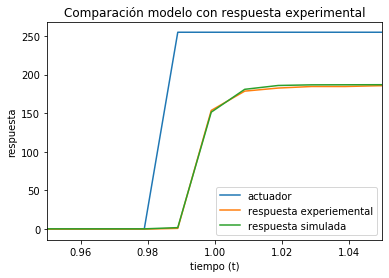

In [13]:
resultado_optimizacion(0.95,1.05)

### 5. Análisis de estabilidad del resultado 

Habiendo identificado el sistema, podemos analizar su estabilidad. Para esto podemos hacer uso del *root_locus*.

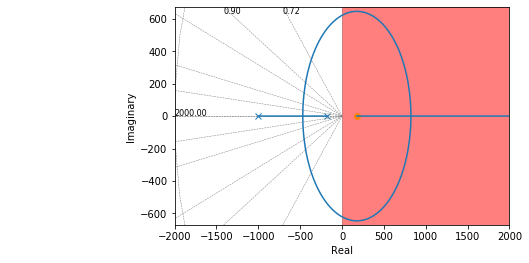

In [14]:
fo = control.tf([gamma],[tau,1])

dt_num,dt_den = control.pade(theta,1)
delay = control.tf(dt_num,dt_den)

fodt = fo*delay

control.root_locus(fodt);
plt.axvspan(0, 2000, facecolor='r', alpha=0.5)
plt.xlim(-2000,2000);

Como nos muestra la gráfica, existen valores de $K$ para los cuales el sistema es inestable. 

### 6. Propuesta de controlador

Como controlador podemos usar un control **PID** o podemos realizar diseñar un controlador por posicionamiento de polos. 

Empecemos con un control **PID**, para este vamos a encontrar la ganancia ultima del sistema $K_u$ y el periodo ultimo $T_u$

In [15]:
import math
pi = math.pi

Ku,_,Fu,_ = control.margin(fodt)
Tu = 2*pi/Fu

print("La ganancia ultima para el sistema experimental es Ku = %2.4f y el periodo último es Tu = %2.4f"%(Ku,Tu))

La ganancia ultima para el sistema experimental es Ku = 1.6057 y el periodo último es Tu = 0.0101


Con estos valores podemos usar la tabla de sintonia de *Ziegler-Nichols*. Para un controlador **PI** tenemos:

In [16]:
s = control.tf([1,0],1)

kp = 0.45*Ku
ti = Tu/1.2
td = 0

K = kp * (1 + 1/(ti*s)+td*s)
display(K)


0.00609 s + 0.7226
------------------
    0.008429 s

Podemos verificar la estabilidad del sistema con este controlador, para esto encontremos los polos del sistema en lazo cerrado. 

In [17]:
G = K * fodt

closed_loop = control.feedback(G,1)
polos = control.pole(closed_loop)
print("Los polos del sistema son: \n\n%s" % ('\n'.join(map(str, polos))))

Los polos del sistema son: 

(-291.01365693028106+292.4067849378002j)
(-291.01365693028106-292.4067849378002j)
(-65.45673473497337+0j)


Como se puede observar todos tiene la parte real negativa, por lo tanto es sistema es estable. 

### 7. Implementación del controlador

Para implementar el **PID** en un sistema de tiempo discreto como lo es un **Arduino** u otro microcontrolador. Debemos discretizar el controlador. Esto se hace con la [transformada $z$](https://en.wikipedia.org/wiki/Bilinear_transform), remplazando: 

$$s \to \frac{2}{T}\frac{z-1}{z+1}$$

donde $T$ es el tiempo de muestreo. 

En python este trabajo lo logramos con *sample_system*:

In [18]:
Kdiscreto = control.sample_system(K,0.01)
display(Kdiscreto)


0.7226 z + 0.1347
-----------------
      z - 1

dt = 0.01

De esta función de transferencia discreta debemos sacar el código que usaremos en el **Arduino**. Para esto debemos construir una ecuación que tenga todos los terminos con $z^n$, con $n$ negativo o zero, de ahí, despejamos el valor del actuador que esta acompañado por $z^0$

In [26]:
z,U,UF,E = sympy.symbols('z U U_k E')

numer = Kdiscreto.num[0][0]
denom = Kdiscreto.den[0][0]

rhs = 0
for i,d in enumerate(denom):
    if i == 0:
        rhs += UF*d*z**(len(denom)-i-1)
    else:
        rhs += U*d*z**(len(denom)-i-1)
lhs = 0
for i,n in enumerate(numer):
    lhs += E*n*z**(len(numer)-i-1)

tfd = sympy.Eq(sympy.expand(rhs/z**(len(numer)-1)),sympy.expand(lhs/z**(len(numer)-1)))
codigo = sympy.Eq(UF,sympy.expand(sympy.solve(tfd,UF)[0]))
display(codigo)

Eq(U_k, 0.722578180449687*E + 0.13470672809478*E/z + 1.0*U/z)

La anterior expresión es la expresión que se programa para el controlador. 

``` C
// CONTROLADOR

E0 = setpoint - float(sensor)   // Calculo del Error

U0 = 0.72*E0 + 0.13*E1 + 1*U1   // Calculo de la expresion para el actuador

E1 = E0  // Guardo el error actual en la variable de error anterior
U1 = U0  // Hago lo mismo para el actuador
```

In [43]:
serialPort = '/dev/ttyACM0'
ser = serial.Serial(serialPort, 115200, timeout=5)
ser.flushInput()
ser.flushOutput()

TC = []
XC = []
YC = []
SC = []

i = 0

E0 = 0
E1 = 0
U1 = 0
U0 = 0
setpoint = 525.0
sensor = 0

while i < 1000 :

    # Controlador
    E0 = setpoint - float(sensor)
    
    U0 = 0.72*E0 + 0.13*E1 + 1*U1
    
    E1 = E0
    U1 = U0
    
    # Enviar datos al actuador
    actuador = max(min(int(U0),255),0)
    ser.write(bytes([actuador]))
    
    # Recibir el mensaje del Arduino
    mensaje = ser.readline()
    ser.flushInput()

    # Mostrar señal 
    if len(mensaje) > 0 :
        data = mensaje.decode().strip('\n').strip('\r').split(",")
        if len(data) == 3:
            print(".", end = "")
            TC.append(float(data[0])/1000)
            XC.append(float(data[1]))
            YC.append(float(data[2]))
            SC.append(setpoint)
            sensor = data[2]
            
    # Incrementar contador
    i += 1

print('\n\n> Completo',end = "")    
ser.write(bytes.fromhex('00'))
ser.close()

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


### 8. Verificacion del controlador

Respuesta del sistema al controlador propuesto

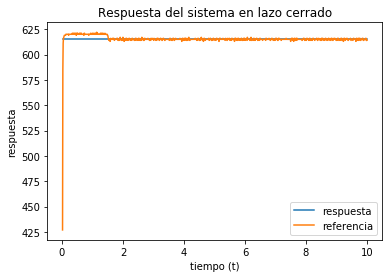

In [42]:
def show_results():
    t = numpy.array(TC)
    x = numpy.array(XC)
    y = numpy.array(YC)
    s = numpy.array(SC)

    x = x.astype(float)
    y = y.astype(float)
    s = s.astype(float)

    ax = plt.subplot(111)
    ax.plot(t[1:],s[1:], label="respuesta")
    ax.plot(t[1:],y[1:], label="referencia")
    #ax.plot(t[1:],x[1:], label="actuador")
    ax.legend()
    plt.title('Respuesta del sistema en lazo cerrado')
    plt.xlabel('tiempo (t)')
    plt.ylabel('respuesta')

show_results()

Otro ejemplo de respuesta

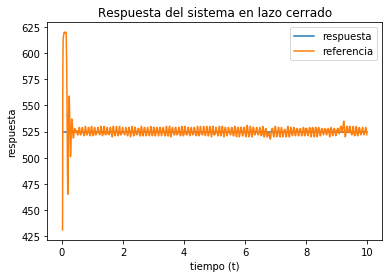

In [44]:
show_results()